This machine learning model predicts claim on an Auto Insurance dataset.

Target feature is TARGET_FLAG: it is a binary variable that can be 0 (car not in a crash, i.e. no claim) or 1 (car in a crash).
Since this is a binary problem, I will consider the following alogorithms:

A) Logistic regression

B) Random forest classifier

I will evaluate model predictions using the following metric selection:

-Confusion matrix and calculation of accuracy, precision and recall;

-ROC (Receiver operating characteristic) curve and AUC (Area under the ROC Curve).

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from scipy import stats
from sklearn.preprocessing import power_transform


# read the data and store data in DataFrame

train_data = pd.read_csv('https://raw.githubusercontent.com/descartes-underwriting/data-scientist-technical-test/main/data/auto-insurance-fall-2017/train_auto.csv')

test_data=pd.read_csv('https://raw.githubusercontent.com/descartes-underwriting/data-scientist-technical-test/main/data/auto-insurance-fall-2017/test_auto.csv')

print("Training data set dimensions, rows x columns:")
print(train_data.shape[0], train_data.shape[1])
print("\nTraining data set features:\n")
print(train_data.columns)
print("\n")
print("Test data set dimensions, rows x columns:")
print(test_data.shape[0], test_data.shape[1])
print("\nTest data set features:\n")
print(test_data.columns)

Training data set dimensions, rows x columns:
8161 26

Training data set features:

Index(['INDEX', 'TARGET_FLAG', 'TARGET_AMT', 'KIDSDRIV', 'AGE', 'HOMEKIDS',
       'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION',
       'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')


Test data set dimensions, rows x columns:
2141 26

Test data set features:

Index(['INDEX', 'TARGET_FLAG', 'TARGET_AMT', 'KIDSDRIV', 'AGE', 'HOMEKIDS',
       'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION',
       'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')


In [214]:
train_data.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [215]:
test_data.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,3,NaN,NaN,0,48.0,0,11.0,"$52,881",No,$0,...,"$21,970",1,Van,yes,$0,0,No,2,10.0,Highly Urban/ Urban
1,9,NaN,NaN,1,40.0,1,11.0,"$50,815",Yes,$0,...,"$18,930",6,Minivan,no,"$3,295",1,No,2,1.0,Highly Urban/ Urban
2,10,NaN,NaN,0,44.0,2,12.0,"$43,486",Yes,$0,...,"$5,900",10,z_SUV,no,$0,0,No,0,10.0,z_Highly Rural/ Rural
3,18,NaN,NaN,0,35.0,2,NaN,"$21,204",Yes,$0,...,"$9,230",6,Pickup,no,$0,0,Yes,0,4.0,z_Highly Rural/ Rural
4,21,NaN,NaN,0,59.0,0,12.0,"$87,460",No,$0,...,"$15,420",1,Minivan,yes,"$44,857",2,No,4,1.0,Highly Urban/ Urban


In [216]:
### DATA PREPROCESSING


# Convert dollars into regular numbers

def convert_dollars(data):
 
    cols=['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']
    data[cols]=data[cols].replace({'\$':'','\,':''},regex=True)
    data[cols]=data[cols].astype('float64')


# Find and remove duplicated rows

def duplicated_rows(data):

    duplicate_rows_df = data[data.duplicated()]
    data = data.drop_duplicates()


# Apply both function on training and testing dataset

convert_dollars(train_data)
convert_dollars(test_data)
    
duplicated_rows(train_data)
duplicated_rows(test_data)

In [217]:
#Saparate predictive features from target;
#Remove INDEX column and TARGET_AMT column

def features_target(data):
    data_features =data.drop(['TARGET_FLAG'], axis=1)
    data_features=data_features.drop(['INDEX'], axis=1)
    data_features=data_features.drop(['TARGET_AMT'], axis=1)
    x = data_features

    y =data.TARGET_FLAG
    return x,y
    
x,y=features_target(train_data)
x_test,y_test=features_target(test_data)

In [218]:
### CHECK FOR COLUMNS WITH NUMERICAL VALUES AND CATEGORICAL VALUES


def locate_numerical_categorical_features(x):
    categorical_cols = [cname for cname in x.columns if x[cname].dtype == "object"]

    numerical_cols = [cname for cname in x.columns if x[cname].dtype in ['int64', 'float64']]

    # Keep selected columns only
    my_cols = categorical_cols + numerical_cols
    x=x[my_cols].copy()
    
    return x,categorical_cols,numerical_cols
    

x,categorical_cols,numerical_cols = locate_numerical_categorical_features(x)
x_test,categorical_cols_test,numerical_cols_test = locate_numerical_categorical_features(x_test)

In [219]:
print("Target prediction is Target Flag.\nTarget flag is a binary variable: 1 if a car is in a crash, 0 elsewhere.")
print("Percentage of car not crashed (0) or crashed (1) in the training dataset:")
print(y.value_counts()/y.shape[0]*100)
print("\n")
print("Predictive features for Target Flag are:")
print(x.columns)
print("\n")
print("Number of categorical and numerical columns")
print(len(categorical_cols),len(numerical_cols))
print("\n")
print("Numerical feature summary")
x.describe()

Target prediction is Target Flag.
Target flag is a binary variable: 1 if a car is in a crash, 0 elsewhere.
Percentage of car not crashed (0) or crashed (1) in the training dataset:
0    73.618429
1    26.381571
Name: TARGET_FLAG, dtype: float64


Predictive features for Target Flag are:
Index(['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'CAR_USE', 'CAR_TYPE',
       'RED_CAR', 'REVOKED', 'URBANICITY', 'KIDSDRIV', 'AGE', 'HOMEKIDS',
       'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM',
       'CLM_FREQ', 'MVR_PTS', 'CAR_AGE'],
      dtype='object')


Number of categorical and numerical columns
10 13


Numerical feature summary


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8155.000000,8161.000000,7707.000000,7716.000000,7697.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.171057,44.790313,0.721235,10.499286,61898.094609,154867.289723,33.485725,15709.899522,5.351305,4037.076216,0.798554,1.695503,8.328323
std,0.511534,8.627589,1.116323,4.092474,47572.682808,129123.774574,15.908333,8419.734075,4.146635,8777.139104,1.158453,2.147112,5.700742
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1500.000000,1.000000,0.000000,0.000000,0.000000,-3.000000
25%,0.000000,39.000000,0.000000,9.000000,28097.000000,0.000000,22.000000,9280.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,45.000000,0.000000,11.000000,54028.000000,161160.000000,33.000000,14440.000000,4.000000,0.000000,0.000000,1.000000,8.000000
75%,0.000000,51.000000,1.000000,13.000000,85986.000000,238724.000000,44.000000,20850.000000,7.000000,4636.000000,2.000000,3.000000,12.000000
max,4.000000,81.000000,5.000000,23.000000,367030.000000,885282.000000,142.000000,69740.000000,25.000000,57037.000000,5.000000,13.000000,28.000000


In [220]:
#Remove negative values from CAR_AGE:
#there is only one negative value, so this may be an entry error and it is removed here

col=x.CAR_AGE

negative_row_index=[ i for i in range(0,col.shape[0])
                     if col[i]<0]
    

print("Number of negative values in CAR_AGE is: ",len(negative_row_index))
x=x.drop(negative_row_index)
y=y.drop(negative_row_index)
print("Updated dataset dimensions: ",x.shape)

Number of negative values in CAR_AGE is:  1
Updated dataset dimensions:  (8160, 23)


In [221]:
print("Categorical feature summary")
x.describe(include=[object])

Categorical feature summary


,PARENT1,MSTATUS,SEX,EDUCATION,JOB,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY
count,8160,8160,8160,8160,7634,8160,8160,8160,8160,8160
unique,2,2,2,5,8,2,6,2,2,2
top,No,Yes,z_F,z_High School,z_Blue Collar,Private,z_SUV,no,No,Highly Urban/ Urban
freq,7083,4894,4374,2330,1825,5131,2294,5782,7161,6491


In [222]:
### CHECK FOR MISSING NUMERICAL VALUES IN THE COLUMNS


# Get names of columns with missing values in training dataset
cols_with_missing = [col for col in x.columns if x[col].isnull().any()]

# Number of missing values in each column of training dataset
missing_val_count_by_column = (x.isnull().sum())

print("Number of columns with missing values in training dataset:")
print(missing_val_count_by_column[missing_val_count_by_column > 0].shape[0])
print("\nIn detail:")
print(missing_val_count_by_column[missing_val_count_by_column > 0])


### FILL MISSING VALUES in NUMERICAL COLUMNS

# Imputation for numerical features

def numerical_imputation(x,numerical_cols,categorical_cols):
    
    my_imputer = SimpleImputer()
    
    x_new = x[numerical_cols].copy()
    imputed_X = pd.DataFrame(my_imputer.fit_transform(x_new))
    
    # Imputation removed column names; put them back
    imputed_X.columns = x_new.columns

    # merge numerical columns and categorical columns
    temp_x_categorical = x[categorical_cols].copy()
    temp_x_categorical.reset_index(inplace=True,drop=True)
    
    x=pd.concat([temp_x_categorical,imputed_X], axis=1)
    
    return x
                  

### FILL MISSING VALUES in CATEGORICAL COLUMNS

# Imputation for categorical features

def categorical_imputation(x,numerical_cols,categorical_cols):
    
    my_imputer = SimpleImputer(strategy='most_frequent')
    
    x_new = x[categorical_cols].copy()
    imputed_X = pd.DataFrame(my_imputer.fit_transform(x_new))

    # Imputation removed column names; put them back
    imputed_X.columns = x_new.columns

    # merge numerical columns and categorical columns
    temp_x_numerical = x[numerical_cols].copy()
    temp_x_numerical.reset_index(inplace=True, drop=True)

    x=pd.concat([imputed_X,temp_x_numerical], axis=1)
    
    return x

  
x=numerical_imputation(x,numerical_cols,categorical_cols)
x=categorical_imputation(x,numerical_cols,categorical_cols)

x_test=numerical_imputation(x_test,numerical_cols_test,categorical_cols_test)
x_test=categorical_imputation(x_test,numerical_cols_test,categorical_cols_test)

#LAST CHECK FOR TRAINING DATASET

# Get names of columns with missing values
cols_with_missing = [col for col in x.columns if x[col].isnull().any()]

# Number of missing values in each column of training data
missing_val_count_by_column = (x.isnull().sum())

print("\nNumber of columns with missing values after imputation:")
print(missing_val_count_by_column[missing_val_count_by_column > 0].shape[0])

Number of columns with missing values in training dataset:
6

In detail:
JOB         526
AGE           6
YOJ         454
INCOME      445
HOME_VAL    464
CAR_AGE     510
dtype: int64

Number of columns with missing values after imputation:
0


In the following I will perform explorative data analyses on the training dataset, in order to define a procedure of feature selection for the two machine learning models A) Logistic regression and B) Random forest classifier.

For the feature selection procedure, I have considered three explorative data analyses:
1) Outliers analysis 

2) Feature Normalization analysis 

3) Pair-wise correlation analysis

Pairs of features with Spearman correlation larger than 0.5 are considered here significantly correlated:

INCOME, HOME_VALU 0.57
CLM_FREQ, OLDCLAIM 0.93


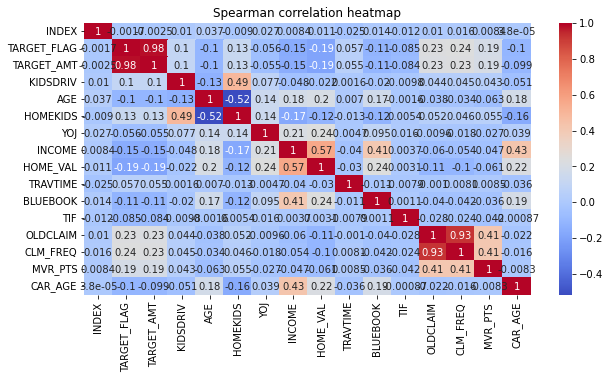

In [223]:
### EXPLORATORY DATA ANALYSIS

### 1. pairwaise Spearman correlation

plt.figure(figsize=(10,5))
c= train_data.corr(method='spearman')
sns.heatmap(c,cmap="coolwarm",annot=True).set(title="Spearman correlation heatmap")

print("Pairs of features with Spearman correlation larger than 0.5 are considered here significantly correlated:\n")
print("INCOME, HOME_VALU 0.57\nCLM_FREQ, OLDCLAIM 0.93")

In [224]:
# High correlated feature pairs could be removed during feature selection

def feature_selection_corr(x,col):
    x=x.drop(col, axis=1)
    return x

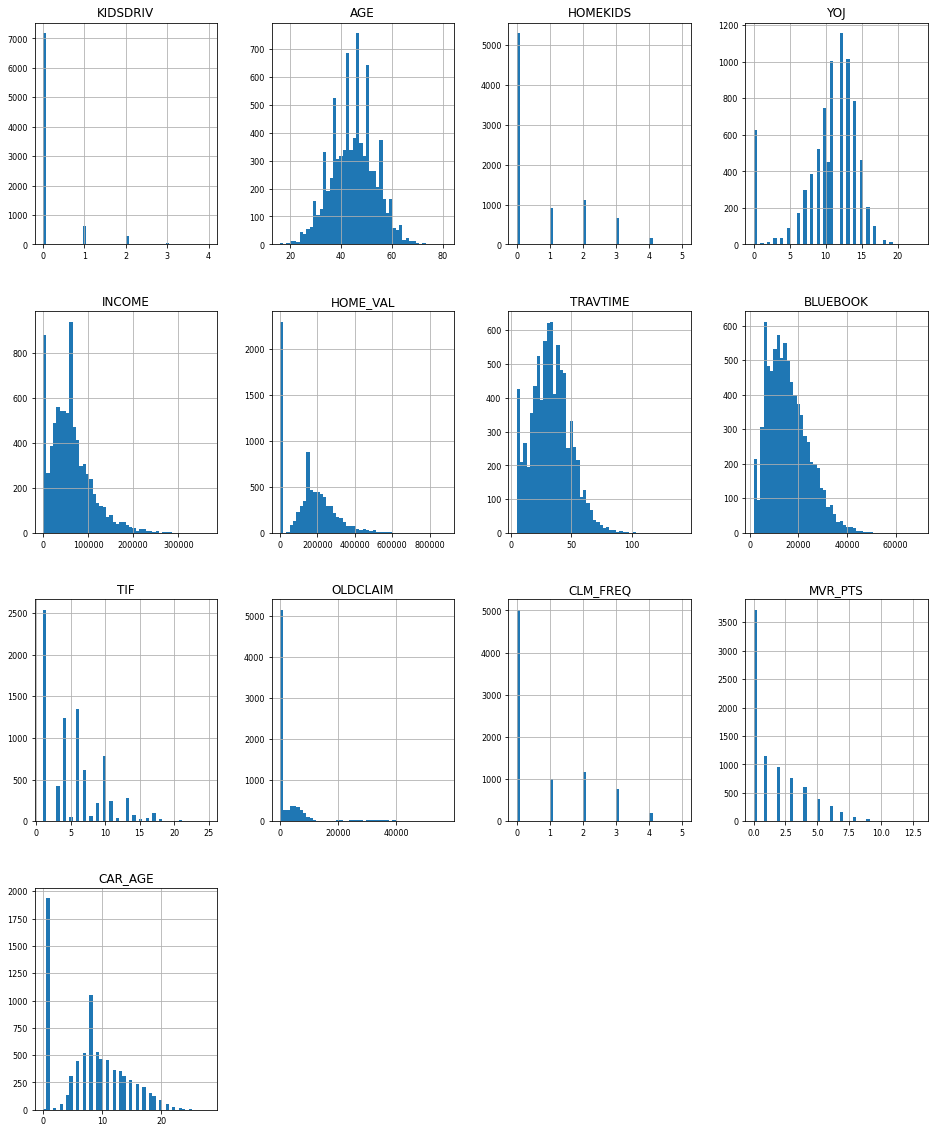

In [225]:
### 2. Numerical features distribution plots

x[numerical_cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [226]:
#Features normalization via Yeo-Johnson normalization could be done in feature selection

def normalization(cols,x):
    x[cols]= power_transform(x[cols],method='yeo-johnson',standardize=False)
    return x

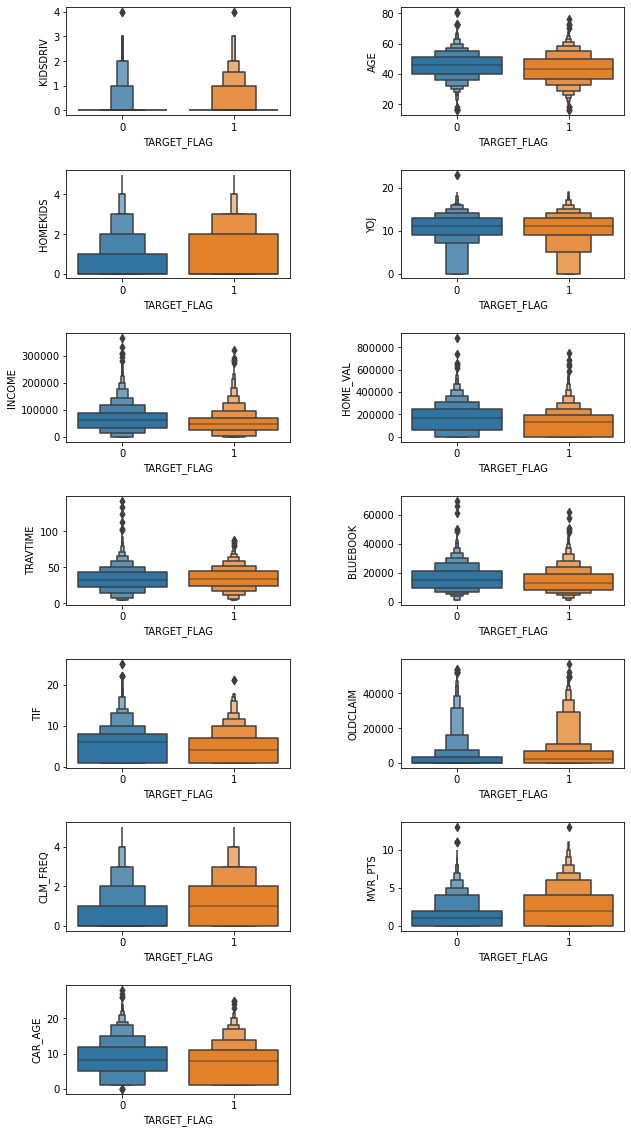

In [227]:
### 3. Outliers analysis: features boxplots

temp=x[numerical_cols]

namecol_list=['KIDSDRIV','AGE','HOMEKIDS','YOJ','INCOME','HOME_VAL',
              'TRAVTIME','BLUEBOOK','TIF','OLDCLAIM','CLM_FREQ','MVR_PTS','CAR_AGE','CAR_AGE']
fig, axs= plt.subplots(7,2,figsize = (10,20))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
for i, ax in enumerate(axs.flat):
    sns.boxenplot(ax=ax,x=y,y=temp[namecol_list[i]])

fig.delaxes(axs[6,1]) # delete final plot -- indexing is zero-based here

In [228]:
# Dealing with the outliers using IQR method

def removeOutliers(df,in_var_name):
    q1=np.quantile(df[in_var_name],0.25)
    q3=np.quantile(df[in_var_name],0.75)
    
    IQR= q3-q1
    
    lower_whisker= q1 - 1.5*IQR
    upper_whisker= q3 + 1.5*IQR
  
    df_out=df[(df[in_var_name]<lower_whisker)|(df[in_var_name]>upper_whisker)]
    df_in=df[(df[in_var_name]>=lower_whisker)&(df[in_var_name]<=upper_whisker)]
    
    print(in_var_name, df_out.shape[0])
    
    return df_in

The following commented code corresponds to feature selection tests that I have performed. I used it to assess the best features for the model training. After this preliminary analysis, I have applied the best feature selection procedure independently for the two models.

In [229]:
#### FEATURE SELECTION AFTER EXPLORATIVE DATA ANALYSIS


### Remove outliers

## merge x, y, to remove lines simultaneously
#tot_frame=pd.concat([x,y], join='inner', axis=1)
#for var_name in numerical_cols:
   # tot_frame = removeOutliers(tot_frame,var_name)

# split back into x,y
#x=tot_frame.iloc[:, 0: x.shape[1]]
#y=tot_frame.iloc[:, -1]


### Feature normalization

#cols=['INCOME','TRAVTIME','BLUEBOOK','MVR_PTS','TIF']
#x=normalization(cols,x)


### Drop high correlated features

#col=['HOME_VAL','OLDCLAIM']   #CLM_FREQ #INCOME
#x=feature_selection_corr(x,col)
#x_test=feature_selection_corr(x_test,col)

## Select numerical columns
#numerical_cols = [cname for cname in x.columns if x[cname].dtype in ['int64', 'float64']]
#numerical_cols_test = [cname for cname in x_test.columns if x_test[cname].dtype in ['int64', 'float64']]

Feature selection has been performed separately for the two models:

A) Logistic Regression
B) Random Forest Classifier

For the feature selection procedure, I have considered three explorative data analyses:

1) Outliers analysis:
Outliers have been located visually using box plots and in quantitative way using the IQR method (https://en.wikipedia.org/wiki/Interquartile_range).

2) Feature Normalization:
Feature probability distributions have been visualized with histograms, and feature normalization has been done using yeo-johnson transformation (https://en.wikipedia.org/wiki/Power_transform).

3) Pair-wise correlation analysis: 
Pair-wise correlation has been calculated using Spearman correlation (https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).



Results are as follows:

1) I have trained and evaluated the models A) and B) keeping and dropping outliers. I have found that for A) the results were similar, while for B) they significantly improved keeping the outliers. In addition, there was no clear indication suggesting that the outliers should be dropped a priori. I have therefore decided to keep them in both A) and B) for subsequent steps.

2) I have considered different combination of numerical features, and I have applied yeo-johnson normalization on their histogram distributions (printed above). I have found that normalization does not significantly affect model performace on both A) and B) case. I have therefore decided to not normalize any numerical feature distribution for subsequent steps. 

3) There are two pairs of significantly correlated features (compared to the chosen threshold of Spearman correlation equal to 0.5):

INCOME     HOME_VAL 0.57

CLM_FREQ   OLDCLAIM 0.93

I have trained and evaluated the models A) and B) by dropping the 4 possible pair combinations of these features, and I found the best model performace by dropping:

A) INCOME, CML_FREQ

B) HOMEVALUE, CLM_FREQ

So, I trained models A) and B) separately according to these two different results.



In [230]:
### ONE HOT ENCODING CATEGORICAL VARIABLES

def one_hot_encoding(x,numerical_cols,categorical_cols):
    #Get list of categorical variables
    s = (x.dtypes  == 'object')
    object_cols = list(s[s].index)
    
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(x[object_cols]))
    OH_cols.columns = OH_encoder.get_feature_names_out(object_cols)
    
    # One-hot encoding removed index; put it back
    OH_cols.index = x.index
    OH_cols.reset_index(inplace=True, drop=True)
    
    ## merge numerical columns and categorical columns
    temp_x_numerical = x[numerical_cols].copy()
    temp_x_numerical.reset_index(inplace=True, drop=True)
    
    x=pd.concat([OH_cols,temp_x_numerical], axis=1)
    
    return x

x=one_hot_encoding(x,numerical_cols,categorical_cols)
x_test=one_hot_encoding(x_test,numerical_cols_test,categorical_cols_test)

In [231]:
##### MODEL TRAINING


#### Logistic regression: Feature selection


### Drop high correlated features

col=['INCOME','CLM_FREQ']
x_logistic=feature_selection_corr(x,col)
x_logistic_test=feature_selection_corr(x_test,col)

## Select numerical columns
numerical_cols = [cname for cname in x_logistic.columns if x_logistic[cname].dtype in ['int64', 'float64']]
numerical_cols_test = [cname for cname in x_logistic_test.columns if x_logistic_test[cname].dtype in ['int64', 'float64']]


# Divide training data into training and validation subsets

x_train, x_val, y_train, y_val = train_test_split(x_logistic, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

print("Dimensions training and validation data set")
print(x_train.shape)
print(x_val.shape)

Dimensions training and validation data set
(6528, 44)
(1632, 44)


In [232]:
#### Logistic regression

model_logistic=LogisticRegression(max_iter=500)
model_logistic.fit(x_train, y_train)
y_pred = model_logistic.predict(x_val)




MODEL EVALUATION LOGISTIC REGRESSION



CONFUSION MATRIX



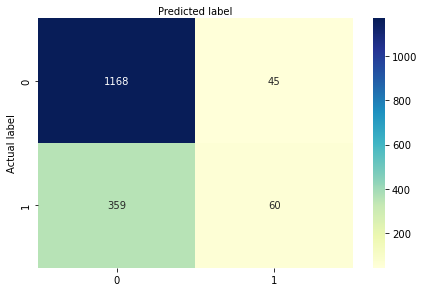

Accuracy: 0.7524509803921569
Precision: 0.5714285714285714
Recall: 0.1431980906921241



ROC CURVE



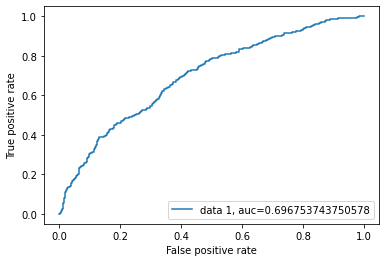

AREA UNDER CURVE= 0.696753743750578


In [233]:
##### MODEL EVALUATION

print("\n\n\nMODEL EVALUATION LOGISTIC REGRESSION\n\n\n")


#Confusion matrix

cnf_matrix = metrics.confusion_matrix(y_val, y_pred)


#Confusion matrix plotted as a heatmap

print("CONFUSION MATRIX\n")
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("\n\n")


## ROC curve and AUC 

print("ROC CURVE\n")

y_pred_proba = model_logistic.predict_proba(x_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

print("AREA UNDER CURVE=",auc)

In [234]:
#### Random forest: Feature selection


### Drop high correlated features

col=['HOME_VAL','CLM_FREQ']
x_forest=feature_selection_corr(x,col)
x_forest_test=feature_selection_corr(x_test,col)

## Select numerical columns
numerical_cols = [cname for cname in x_forest.columns if x_forest[cname].dtype in ['int64', 'float64']]
numerical_cols_test = [cname for cname in x_forest_test.columns if x_forest_test[cname].dtype in ['int64', 'float64']]


# Divide training data into training and validation subsets

x_train, x_val, y_train, y_val = train_test_split(x_forest, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

print("Dimensions training and validation data set")
print(x_train.shape)
print(x_val.shape)

Dimensions training and validation data set
(6528, 44)
(1632, 44)


In [235]:
########### RandomForestClassifier


# Number of trees in random forest
n_estimators =[100,200,300]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [ 50, 100,200]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,

              }


model_base = RandomForestClassifier()
model_forest = RandomizedSearchCV(estimator = model_base,
                               param_distributions = random_grid,
                               n_iter = 10, cv = 5,
                               verbose=2,
                               random_state=1, n_jobs = 4) 
model_forest.fit(x_train, y_train)
y_pred = model_forest.predict(x_val)


print("Best parameters:")
print(model_forest.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:
{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 200}





MODEL EVALUATION RANDOM FOREST CLASSIFIER



CONFUSION MATRIX



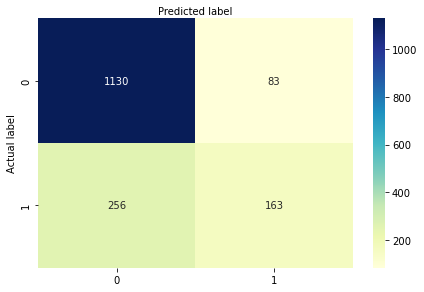

Accuracy: 0.7922794117647058
Precision: 0.6626016260162602
Recall: 0.38902147971360385



ROC CURVE



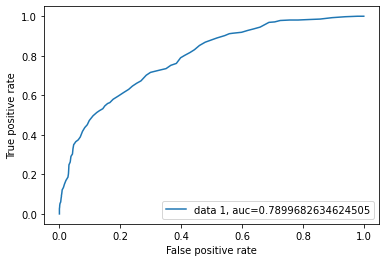

AREA UNDER CURVE= 0.7899682634624505


In [236]:
##### MODEL EVALUATION

print("\n\n\nMODEL EVALUATION RANDOM FOREST CLASSIFIER\n\n\n")


#Confusion matrix

cnf_matrix = metrics.confusion_matrix(y_val, y_pred)


#Confusion matrix plotted as a heatmap

print("CONFUSION MATRIX\n")
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("\n\n")


## ROC curve and AUC 

print("ROC CURVE\n")

y_pred_proba = model_forest.predict_proba(x_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

print("AREA UNDER CURVE=",auc)

CONCLUSIONS

According to feature selection and the metric criteria used here, Random Forest performs better than Logistic Regression on the training dataset.

As the last step of this technical test, both the models are applied on the test dataset, and the final results is printed in two output files: Target_Prediction_Logistic_Regression.csv and Target_Prediction_Random_Forest.csv.

In [237]:
###PREDICTIONS

y_pred_logistic = model_logistic.predict(x_logistic_test);
y_pred_forest = model_forest.predict(x_forest_test);


output = pd.DataFrame({'TARGET_FLAG': y_pred_logistic})
output.to_csv('Target_Prediction_Logistic_Regression.csv', index=False)

output = pd.DataFrame({'TARGET_FLAG': y_pred_forest})
output.to_csv('Target_Prediction_Random_Forest.csv', index=False)